In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

In [2]:
data_dir = 't2'
data_transform = transforms.Compose([
        transforms.ToTensor()])

#        transforms.Normalize([0.485, 0.456, 0.406], [0.5, 0.5, 0.5])

image_datasets = datasets.ImageFolder(data_dir, data_transform)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=True)
class_names = image_datasets.classes

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

meta_model = models.vgg16()
meta_model.classifier[6] = nn.Linear(4096, 7)
meta_model.load_state_dict(torch.load('metaVGG16'))
meta_model.eval(), meta_model.to(device);


In [4]:
vgg_model_dict = dict(type='vgg', arch=meta_model, layer_name='features_29', input_size=(224, 224))
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)

saliency_map size : torch.Size([14, 14])


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.5, 0.5, 0.5])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
def visualize_model(model, num_images=7, vgg_gradcampp=vgg_gradcampp):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, labels) in enumerate(dataloaders):
        with torch.no_grad():
            inputs1 = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs1)
            _, preds = torch.max(outputs, 1)
        

        cam_out = []
        mask_pp, _ = vgg_gradcampp(inputs.to(device))
        heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), inputs.cpu())
                
        cam_out.append(torch.stack([inputs.squeeze().cpu(), result_pp], 0))
                
        cam_out = make_grid(torch.cat(cam_out, 0), nrow=3)
            

        images_so_far += 1
        print(images_so_far)
#         ax = plt.subplot(num_images//2, 2, images_so_far)
#         ax.axis('off')
#         ax.set_title('predicted: {} ground truth: {}'.format(class_names[preds],class_names[labels]))
        imshow(cam_out.cpu(), title=('predicted: {} ground truth: {}'.format(class_names[preds],class_names[labels])))

        if images_so_far == num_images:
            model.train(mode=was_training)
            return
            
    model.train(mode=was_training)

1


/home/bdggj/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


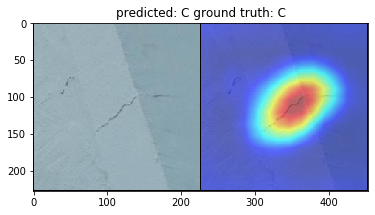

2


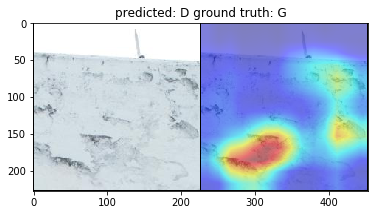

3


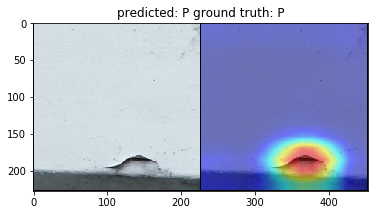

4


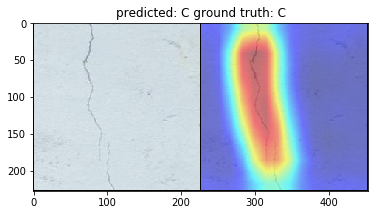

5


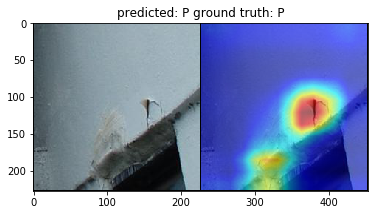

6


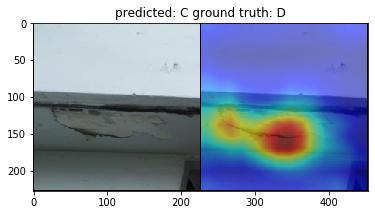

7


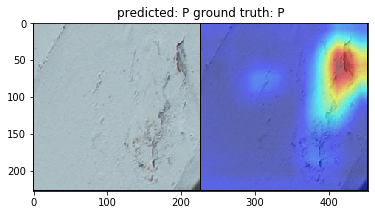

In [7]:
visualize_model(meta_model)